In [1]:
import os
import pickle
import numpy as np
np.random.seed(42)
import pandas as pd
import keras
from keras.models import Model
from keras.layers import Embedding, Dense, Dropout, Input, Concatenate, Flatten, Reshape
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
from sklearn.model_selection import train_test_split as splt
import matplotlib.pyplot as plt
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

Using TensorFlow backend.


In [2]:
dfy = pd.read_csv("MILANO_wSCORE.csv")
dfx = pd.read_csv("PLIC-milano-processed.csv", sep=";")

/home/webvalley/anaconda3/envs/score/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (14,29,36,44,51,94,104,105,112,113,120,127,130,149,158,168,237,239,240,241,248,249,256,273,298) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Thresholds are 0 - 0.01, 0.01 - 0.02, 0.02 - 0.05, 0.05 - 1
y = dfy["SCORE"].values/100
y_cat = np.zeros((y.shape[0], 4))
for i, val in enumerate(y):
    if(val < 0.01):
        y_cat[i][0] = 1
    elif(val < 0.02):
        y_cat[i][1] = 1
    elif(val < 0.05):
        y_cat[i][2] = 1
    else:
        y_cat[i][3] = 1

In [4]:
dfx = dfx.select_dtypes(exclude=['object'])
# dfx = dfx.replace(-1, np.nan).replace("-1", np.nan).replace(-1.0, np.nan)
dfx = dfx.drop(labels = ['Unnamed: 0', 'Unnamed: 0.1', 'cod pcs'], axis=1) 
dfx = dfx.dropna(how='any', axis=1)
dfx = dfx.drop([col for col in dfx.columns if "date" in col], axis = 1)

In [5]:
def joi(df, df2, sta):
    for st in sta:
        df2 = df2.join(df[st])
    return df2

dfxFloats = dfx.select_dtypes(include = 'float')
dfxInt = dfx.select_dtypes(include = 'int')
dfxFloats = joi(dfx, dfxFloats, [a for a in dfxInt.columns if (dfxInt[a].max()) > 1])
dfxInt = dfxInt.drop([a for a in dfxInt.columns if (dfxInt[a].max()) > 1], axis = 1)
dfxInt = dfxInt[dfxInt.columns[dfxInt.max()>0]]

In [6]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 2000)
    pd.set_option('display.float_format', '{:20,.2f}'.format)
    pd.set_option('display.max_colwidth', -1)
    print(x)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.float_format')
    pd.reset_option('display.max_colwidth')
#print_full(dfxInt.max())
#print_full(dfxFloats.max())

In [7]:
xCat = dfxInt.values + np.ones(dfxInt.values.shape) + np.ones(dfxInt.values.shape)
xCont = dfxFloats.values

In [8]:
print(xCat.shape)
print(xCont.shape)

(5780, 79)
(5780, 93)


In [9]:
contIn = Input(shape=(xCont.shape[1],))
catIn = Input(shape=(xCat.shape[1],))

no_of_unique_cat  = len(np.unique(xCat))
embedding_size = min(np.ceil((no_of_unique_cat)/2), 50 )
embedding_size = int(embedding_size)
vocab  = no_of_unique_cat+1

catBranch = Embedding(vocab ,embedding_size)(catIn)
catBranch = Dense(16, activation='sigmoid')(catBranch)
catBranch = Dropout(0.5)(catBranch)

catBranch = Flatten()(catBranch)

# catBranch = Reshape(target_shape=(16, ))(catBranch)

# catBranch = Embedding(3000, 32, input_length=79)(catIn)
#print(catBranch)
# catBranch = Flatten()(catBranch)
#print(catBranch)

contBranch = Dense(32, activation='sigmoid', )(contIn)
contBranch = Dropout(0.5)(contBranch)
contBranch = Dense(16, activation='sigmoid')(contBranch)
contBranch = Dropout(0.5)(contBranch)

catBranch = Dense(16, activation='sigmoid')(catBranch)
catBranch = Dropout(0.5)(catBranch)
catBranch = Dense(16, activation='sigmoid')(catBranch)
catBranch = Dropout(0.5)(catBranch)


model = Concatenate()([contBranch, catBranch])
output = Dense(4, activation='softmax')(model)

model = Model(inputs = [contIn, catIn], outputs = [output])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [10]:
x_Cat_tr, x_Cat_ts, x_Cont_tr, x_Cont_ts, y_tr, y_ts = splt(xCat, xCont, y_cat, test_size=0.25, random_state=42)

In [11]:
es = EarlyStopping(patience = 100, restore_best_weights = True)
history = model.fit(x=[x_Cont_tr, x_Cat_tr], y=y_tr, validation_data=([x_Cont_ts, x_Cat_ts], y_ts), epochs=500, callbacks = [es])

Instructions for updating:
Use tf.cast instead.
Train on 4335 samples, validate on 1445 samples
Epoch 1/500
4335/4335 [==============================] - 1s 250us/step - loss: 1.5673 - acc: 0.2685 - val_loss: 1.3472 - val_acc: 0.3439
Epoch 2/500
4335/4335 [==============================] - 0s 72us/step - loss: 1.4555 - acc: 0.2923 - val_loss: 1.3374 - val_acc: 0.3758
Epoch 3/500
4335/4335 [==============================] - 0s 74us/step - loss: 1.4066 - acc: 0.3089 - val_loss: 1.3279 - val_acc: 0.3723
Epoch 4/500
4335/4335 [==============================] - 0s 72us/step - loss: 1.3710 - acc: 0.3257 - val_loss: 1.3138 - val_acc: 0.3834
Epoch 5/500
4335/4335 [==============================] - 0s 74us/step - loss: 1.3475 - acc: 0.3451 - val_loss: 1.2909 - val_acc: 0.4436
Epoch 6/500
4335/4335 [==============================] - 0s 71us/step - loss: 1.3270 - acc: 0.3672 - val_loss: 1.2632 - val_acc: 0.4484
Epoch 7/500
4335/4335 [==============================] - 0s 69us/step - loss: 1.2912 - 

4335/4335 [==============================] - 0s 69us/step - loss: 0.9872 - acc: 0.5663 - val_loss: 0.9020 - val_acc: 0.5827
Epoch 59/500
4335/4335 [==============================] - 0s 72us/step - loss: 0.9744 - acc: 0.5585 - val_loss: 0.9095 - val_acc: 0.5827
Epoch 60/500
4335/4335 [==============================] - 0s 73us/step - loss: 0.9899 - acc: 0.5546 - val_loss: 0.8993 - val_acc: 0.5972
Epoch 61/500
4335/4335 [==============================] - 0s 70us/step - loss: 0.9684 - acc: 0.5580 - val_loss: 0.8828 - val_acc: 0.6007
Epoch 62/500
4335/4335 [==============================] - 0s 73us/step - loss: 0.9728 - acc: 0.5670 - val_loss: 0.8827 - val_acc: 0.5972
Epoch 63/500
4335/4335 [==============================] - 0s 71us/step - loss: 0.9755 - acc: 0.5668 - val_loss: 0.8805 - val_acc: 0.5986
Epoch 64/500
4335/4335 [==============================] - 0s 72us/step - loss: 0.9677 - acc: 0.5716 - val_loss: 0.8805 - val_acc: 0.5965
Epoch 65/500
4335/4335 [==============================

Epoch 118/500
4335/4335 [==============================] - 0s 73us/step - loss: 0.8864 - acc: 0.5963 - val_loss: 0.8029 - val_acc: 0.6388
Epoch 119/500
4335/4335 [==============================] - 0s 72us/step - loss: 0.8913 - acc: 0.5988 - val_loss: 0.8248 - val_acc: 0.6215
Epoch 120/500
4335/4335 [==============================] - 0s 75us/step - loss: 0.8584 - acc: 0.6125 - val_loss: 0.8012 - val_acc: 0.6422
Epoch 121/500
4335/4335 [==============================] - 0s 70us/step - loss: 0.8906 - acc: 0.6048 - val_loss: 0.7928 - val_acc: 0.6547
Epoch 122/500
4335/4335 [==============================] - 0s 69us/step - loss: 0.8607 - acc: 0.6051 - val_loss: 0.8140 - val_acc: 0.6277
Epoch 123/500
4335/4335 [==============================] - 0s 72us/step - loss: 0.8611 - acc: 0.6185 - val_loss: 0.7850 - val_acc: 0.6561
Epoch 124/500
4335/4335 [==============================] - 0s 73us/step - loss: 0.8703 - acc: 0.6055 - val_loss: 0.7895 - val_acc: 0.6491
Epoch 125/500
4335/4335 [=========

4335/4335 [==============================] - 0s 68us/step - loss: 0.8180 - acc: 0.6408 - val_loss: 0.7739 - val_acc: 0.6484
Epoch 178/500
4335/4335 [==============================] - 0s 73us/step - loss: 0.8328 - acc: 0.6245 - val_loss: 0.7528 - val_acc: 0.6796
Epoch 179/500
4335/4335 [==============================] - 0s 71us/step - loss: 0.8255 - acc: 0.6256 - val_loss: 0.7377 - val_acc: 0.6775
Epoch 180/500
4335/4335 [==============================] - 0s 71us/step - loss: 0.8085 - acc: 0.6353 - val_loss: 0.7351 - val_acc: 0.6740
Epoch 181/500
4335/4335 [==============================] - 0s 74us/step - loss: 0.8271 - acc: 0.6293 - val_loss: 0.7546 - val_acc: 0.6830
Epoch 182/500
4335/4335 [==============================] - 0s 71us/step - loss: 0.8225 - acc: 0.6383 - val_loss: 0.7379 - val_acc: 0.6872
Epoch 183/500
4335/4335 [==============================] - 0s 71us/step - loss: 0.8293 - acc: 0.6291 - val_loss: 0.7387 - val_acc: 0.7003
Epoch 184/500
4335/4335 [=======================

4335/4335 [==============================] - 0s 70us/step - loss: 0.7830 - acc: 0.6572 - val_loss: 0.7094 - val_acc: 0.6976
Epoch 237/500
4335/4335 [==============================] - 0s 77us/step - loss: 0.7778 - acc: 0.6565 - val_loss: 0.7796 - val_acc: 0.6388
Epoch 238/500
4335/4335 [==============================] - 0s 72us/step - loss: 0.8060 - acc: 0.6348 - val_loss: 0.7344 - val_acc: 0.6969
Epoch 239/500
4335/4335 [==============================] - 0s 66us/step - loss: 0.7985 - acc: 0.6574 - val_loss: 0.7036 - val_acc: 0.7149
Epoch 240/500
4335/4335 [==============================] - 0s 71us/step - loss: 0.7843 - acc: 0.6533 - val_loss: 0.7133 - val_acc: 0.7024
Epoch 241/500
4335/4335 [==============================] - 0s 75us/step - loss: 0.7897 - acc: 0.6484 - val_loss: 0.7374 - val_acc: 0.6824
Epoch 242/500
4335/4335 [==============================] - 0s 70us/step - loss: 0.7798 - acc: 0.6450 - val_loss: 0.7114 - val_acc: 0.7052
Epoch 243/500
4335/4335 [=======================

4335/4335 [==============================] - 0s 72us/step - loss: 0.7557 - acc: 0.6664 - val_loss: 0.6807 - val_acc: 0.7197
Epoch 296/500
4335/4335 [==============================] - 0s 74us/step - loss: 0.7717 - acc: 0.6591 - val_loss: 0.6895 - val_acc: 0.6934
Epoch 297/500
4335/4335 [==============================] - 0s 69us/step - loss: 0.7384 - acc: 0.6796 - val_loss: 0.6986 - val_acc: 0.6976
Epoch 298/500
4335/4335 [==============================] - 0s 76us/step - loss: 0.7502 - acc: 0.6773 - val_loss: 0.6818 - val_acc: 0.7163
Epoch 299/500
4335/4335 [==============================] - 0s 69us/step - loss: 0.7571 - acc: 0.6660 - val_loss: 0.6762 - val_acc: 0.7232
Epoch 300/500
4335/4335 [==============================] - 0s 72us/step - loss: 0.7628 - acc: 0.6660 - val_loss: 0.6829 - val_acc: 0.7052
Epoch 301/500
4335/4335 [==============================] - 0s 74us/step - loss: 0.7629 - acc: 0.6694 - val_loss: 0.7222 - val_acc: 0.6720
Epoch 302/500
4335/4335 [=======================

4335/4335 [==============================] - 0s 68us/step - loss: 0.7325 - acc: 0.6840 - val_loss: 0.6676 - val_acc: 0.7260
Epoch 355/500
4335/4335 [==============================] - 0s 71us/step - loss: 0.7381 - acc: 0.6824 - val_loss: 0.6675 - val_acc: 0.7301
Epoch 356/500
4335/4335 [==============================] - 0s 73us/step - loss: 0.7376 - acc: 0.6805 - val_loss: 0.6746 - val_acc: 0.7543
Epoch 357/500
4335/4335 [==============================] - 0s 75us/step - loss: 0.7581 - acc: 0.6614 - val_loss: 0.6747 - val_acc: 0.7253
Epoch 358/500
4335/4335 [==============================] - 0s 73us/step - loss: 0.7336 - acc: 0.6761 - val_loss: 0.6658 - val_acc: 0.7260
Epoch 359/500
4335/4335 [==============================] - 0s 68us/step - loss: 0.7324 - acc: 0.6664 - val_loss: 0.6861 - val_acc: 0.7232
Epoch 360/500
4335/4335 [==============================] - 0s 75us/step - loss: 0.7333 - acc: 0.6777 - val_loss: 0.6862 - val_acc: 0.7163
Epoch 361/500
4335/4335 [=======================

4335/4335 [==============================] - 0s 72us/step - loss: 0.7252 - acc: 0.6934 - val_loss: 0.6613 - val_acc: 0.7384
Epoch 414/500
4335/4335 [==============================] - 0s 72us/step - loss: 0.7312 - acc: 0.6856 - val_loss: 0.6581 - val_acc: 0.7356
Epoch 415/500
4335/4335 [==============================] - 0s 75us/step - loss: 0.7277 - acc: 0.6881 - val_loss: 0.6681 - val_acc: 0.7114
Epoch 416/500
4335/4335 [==============================] - 0s 73us/step - loss: 0.7315 - acc: 0.6860 - val_loss: 0.6838 - val_acc: 0.7156
Epoch 417/500
4335/4335 [==============================] - 0s 70us/step - loss: 0.7562 - acc: 0.6662 - val_loss: 0.6491 - val_acc: 0.7246
Epoch 418/500
4335/4335 [==============================] - 0s 75us/step - loss: 0.7111 - acc: 0.6955 - val_loss: 0.6597 - val_acc: 0.7225
Epoch 419/500
4335/4335 [==============================] - 0s 75us/step - loss: 0.7251 - acc: 0.6828 - val_loss: 0.6853 - val_acc: 0.7017
Epoch 420/500
4335/4335 [=======================

4335/4335 [==============================] - 0s 72us/step - loss: 0.6920 - acc: 0.7029 - val_loss: 0.6567 - val_acc: 0.7433
Epoch 473/500
4335/4335 [==============================] - 0s 77us/step - loss: 0.7235 - acc: 0.6881 - val_loss: 0.6829 - val_acc: 0.7260
Epoch 474/500
4335/4335 [==============================] - 0s 80us/step - loss: 0.7056 - acc: 0.6923 - val_loss: 0.6875 - val_acc: 0.7253
Epoch 475/500
4335/4335 [==============================] - 0s 73us/step - loss: 0.7303 - acc: 0.6800 - val_loss: 0.6550 - val_acc: 0.7460
Epoch 476/500
4335/4335 [==============================] - 0s 73us/step - loss: 0.7205 - acc: 0.6962 - val_loss: 0.6535 - val_acc: 0.7349
Epoch 477/500
4335/4335 [==============================] - 0s 71us/step - loss: 0.7089 - acc: 0.7036 - val_loss: 0.6592 - val_acc: 0.7232
Epoch 478/500
4335/4335 [==============================] - 0s 73us/step - loss: 0.7187 - acc: 0.6934 - val_loss: 0.6921 - val_acc: 0.7024
Epoch 479/500
4335/4335 [=======================

In [12]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]

    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    
    print( max(history.history['val_acc']))
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

0.7660899653979238


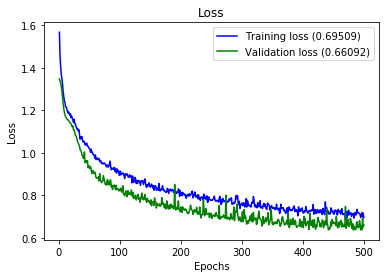

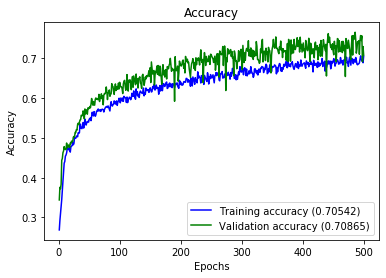

In [13]:
plot_history(history)

In [14]:
#79.377